<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io
import tqdm
import torch
from torch.utils.data import DataLoader

In [6]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [7]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [8]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [9]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [10]:
print(np.shape(simulation_train[0]),type(simulation_train),simulation_train[0][0])
print(len(simulation_train))

(103, 2) <class 'list'> [-2.35932245  0.06356978]
800


In [11]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

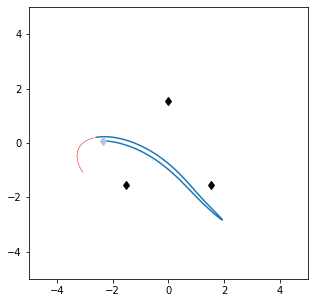

Charges are [-0.75079983 -0.27656042 -0.16604467]


In [12]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [13]:
# train_tokenized = [(torch.tensor(simulation_train[i][:,0], dtype=torch.int64), 
#                     torch.tensor(charges_train[i], dtype=torch.int64)) 
#                     for i in range(len(simulation_train))]
# test_tokenized = [(torch.tensor(simulation_train[i][:,0], dtype=torch.int64), 
#                     torch.tensor(charges_train[i], dtype=torch.int64)) 
#                     for i in range(len(simulation_train))]
train_tokenized = [(torch.tensor(simulation_train[i]), 
                    torch.tensor(charges_train[i])) 
                    for i in range(len(simulation_train))]
test_tokenized = [(torch.tensor(simulation_test[i]), 
                    torch.tensor(charges_test[i])) 
                    for i in range(len(simulation_test))]

In [14]:
train_dataloader = DataLoader(train_tokenized, batch_size=1)
test_dataloader = DataLoader(test_tokenized, batch_size=1)

In [15]:
print(len(train_tokenized),train_tokenized[0][0].shape,train_tokenized[0][1])

800 torch.Size([103, 2]) tensor([-0.9951, -0.4482, -0.2730], dtype=torch.float64)


In [16]:
max_x, max_y = np.max(np.vstack(simulation_train),axis=0)
min_x, min_y = np.min(np.vstack(simulation_train),axis=0)
print(min_x, min_y, max_x, max_y)

-5.310629703652528 -7.312594880170194 6.57562762750751 6.240379282743553


In [346]:
np.max(np.array(simulation_train[0]),axis=0)
#simulation_train[0]

array([1.66485016, 0.95460722])

In [181]:
charges_train[0]

array([-0.99508806, -0.44820919, -0.2730329 ])

In [17]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # sentences are stored as tuples; get respective lists
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sim_list = [x[0] for x in batch]
    data_length = [len(x[0]) for x in batch]
    charge_list = [x[1] for x in batch]

    # pad sequences in batch
    sim_padded = pad_sequence(sequences = sim_list, 
                             batch_first = True, 
                             padding_value = 0)
    charge_padded = pad_sequence(sequences = charge_list, 
                             batch_first = True, 
                             padding_value = 0)

    # return source (DE) and target sequences (EN) after transferring them to GPU (if available)
    return sim_padded, charge_padded, data_length

In [18]:
data_loader = DataLoader(train_tokenized, batch_size=3, shuffle=True, 
                             collate_fn=collate_batch)
batch_x, batch_y, batch_len = iter(data_loader).next()
print(batch_x.size(), batch_y.size(), batch_len)
batch_x_pack = torch.nn.utils.rnn.pack_padded_sequence(batch_x, 
                                                 batch_len, batch_first=True)

torch.Size([3, 110, 2]) torch.Size([3, 3]) [110, 106, 99]


In [19]:
def squash_packed(x, fn=torch.tanh):
    return torch.nn.utils.rnn.PackedSequence(fn(x.data), x.batch_sizes, 
                 x.sorted_indices, x.unsorted_indices)

In [21]:
d_model=128
x = torch.nn.utils.rnn.pack_padded_sequence(torch.rand(6, 2, d_model), torch.tensor([6, 3]))
l = torch.nn.Linear(d_model, d_model)
squash_packed(x, l)

PackedSequence(data=tensor([[-0.0677,  0.2708, -0.1277,  ..., -0.1773,  0.4477, -0.3126],
        [-0.2433,  0.1584, -0.1957,  ...,  0.3387,  0.8205, -0.4784],
        [ 0.2117,  0.1083, -0.2905,  ...,  0.0634,  0.4532, -0.4538],
        ...,
        [ 0.3050,  0.0723,  0.0977,  ...,  0.2710,  0.5798, -0.2817],
        [ 0.4926, -0.0923, -0.1225,  ..., -0.1561,  0.5141, -0.4602],
        [-0.2325, -0.0787, -0.4290,  ...,  0.3887,  0.4746, -0.4714]],
       grad_fn=<AddmmBackward0>), batch_sizes=tensor([2, 2, 2, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [437]:
batch_x[2].size()

torch.Size([103, 2])

In [439]:
batch_x_pack.batch_sizes

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 2, 2])

In [430]:
seq_batch = [torch.tensor([[1, 1],
                           [2, 2],
                           [3, 3],
                           [4, 4],
                           [5, 5]]),
             torch.tensor([[10, 10],
                           [20, 20]])]
seq_lens = [5, 2]
padded_seq_batch = torch.nn.utils.rnn.pad_sequence(seq_batch, batch_first=True)

In [434]:
padded_seq_batch[1]

tensor([[10, 10],
        [20, 20],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0]])

In [436]:
packed_seq_batch = torch.nn.utils.rnn.pack_padded_sequence(padded_seq_batch, lengths=seq_lens, batch_first=True)

In [438]:
packed_seq_batch.batch_sizes

tensor([2, 2, 1, 1, 1])

## Model Implementation

In [198]:
from torch import nn

class RNNClassificationModel(nn.Module):

    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim
        
        #self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        #make output in [-1,0]
        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, seq):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        h = seq.float()    
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(h)
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        last_timestep = out[:,-1]
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred


In [443]:
from torch import nn

class RNNClassificationModel(nn.Module):

    def __init__(self, embed_dim, n_layers, hidden_dim):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim

        self.input_embedding_layer = nn.Linear(2, self.embed_dim)
        
        #self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        #make output in [-1,0]
        self.fc2 = nn.Linear(hidden_dim, 3)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, seq):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        seq = seq.float() 
        h = self.input_embedding_layer(seq)
           
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(h)
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        last_timestep = out[:,-1]
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred


## Model Training

In [444]:
model = RNNClassificationModel(embed_dim=64, 
                               n_layers = 1, 
                               hidden_dim=128)

In [328]:
test_dataloader = DataLoader(test_tokenized, batch_size=1)
src, trg = next(iter(test_dataloader))

In [330]:
src.size()
#src.dtype

torch.Size([1, 95, 2])

In [332]:
src = src.float()
h = model.input_embedding_layer(src)

In [334]:
h.size()

torch.Size([1, 95, 10])

In [327]:
out, (hidden, _) = model.rnn(src.float())
last_timestep = out[:,-1]

RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 2

In [89]:
last_timestep.shape

torch.Size([1, 128])

In [83]:
y_pred = model(src)

In [85]:
y_pred
y_pred.argmax(dim=-1) 

tensor([0])

In [227]:
iterator = iter(train_dataloader)
losses=[]

In [230]:
text_batch, y_true = next(iterator)
print(text_batch.size(),y_true.size())
y_pred = model(text_batch)
print(y_true, y_pred)
loss = model.criterion(y_pred, y_true)
losses.append(loss.item())

torch.Size([1, 97, 2]) torch.Size([1, 3])
tensor([[-0.9845, -0.1668, -0.3479]], dtype=torch.float64) tensor([[-0.4922, -0.4652, -0.5890]], grad_fn=<AddmmBackward0>)


In [231]:
print(losses)

[0.1072337826899493, 0.1298474854360123]


In [387]:
train_dataloader = DataLoader(train_tokenized, batch_size=3, shuffle=True, 
                             collate_fn=collate_batch)

batch_x, y_true, batch_len=next(iter((train_dataloader)))

text_batch = torch.nn.utils.rnn.pack_padded_sequence(batch_x, 
                                            batch_len, batch_first=True)

In [388]:
#model(text_batch)
text_batch = text_batch.float() 
print(text_batch.shape())
h = model.input_embedding_layer(text_batch)

AttributeError: 'PackedSequence' object has no attribute 'shape'

In [389]:
text_batch

PackedSequence(data=tensor([[ 2.3589, -0.1808],
        [ 0.0692, -2.3595],
        [-2.3596, -0.0813],
        [ 2.2497, -0.1710],
        [ 0.0539, -2.2521],
        [-2.2535, -0.0808]]), batch_sizes=tensor([3, 3]), sorted_indices=None, unsorted_indices=None)

In [378]:
import time
from torch.nn.functional import softmax

def train(dataloader):

    rmse_losses = []
    mse_losses = []
    
    model.train()
    
    total_acc, total_count = 0, 0
    start_time = time.time()
    for (text_batch, y_true, batch_len) in tqdm.tqdm(dataloader):

        # text_batch = torch.nn.utils.rnn.pack_padded_sequence(batch_x, 
        #                                                 batch_len, batch_first=True)
                
        model.optimizer.zero_grad()

        y_true = y_true.to(torch.float32)
        
        y_pred = model(text_batch, batch_len) #shape (batch_size, num_classes) 
        #print(1)

        #y_class = y_pred.argmax(dim=-1) 
        
#         y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
        
        mse_loss = model.criterion(y_pred, y_true)
        mse_losses.append(mse_loss.item())
        rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

        rmse_losses.append(rmse_loss.item())
        
        mse_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()
        
        
        
        #total_acc += (y_class == y_true).sum().item()
        #total_count += y_true.size(0)
        
  
            
    return mse_losses, rmse_losses

def evaluate(dataloader):
    
    rmse_losses = []
    mse_losses = []

    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text_batch, y_true) in enumerate(dataloader):
            
            y_pred = model(text_batch) #shape (batch_size, num_classes) 
            
            #y_class = y_pred.argmax(dim=-1) 
            
#             y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
            
            mse_loss = model.criterion(y_pred, y_true)
            mse_losses.append(mse_loss.item())
            rmse_loss = torch.sqrt(model.criterion(y_pred, y_true))

            rmse_losses.append(rmse_loss.item())

            
            #total_acc += (y_class == y_true).sum().item()
            #total_count += y_true.size(0)

    return mse_losses, rmse_losses

In [379]:
EPOCHS = 20 # epoch
BATCH_SIZE = 1


train_loss_mse, train_loss_rmse, val_loss_mse, val_loss_rmse = [], [], [], []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
    test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE, shuffle=True, 
                             collate_fn=collate_batch)
    # train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE)
    # test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE)
    
    train_loss_mse_epoch, train_loss_rmse_epoch = train(train_dataloader)
    train_loss_mse.append(train_loss_mse_epoch)
    train_loss_rmse.append(train_loss_rmse_epoch)
    val_loss_mse_epoch, val_loss_rmse_epoch = evaluate(test_dataloader)
    val_loss_mse.append(val_loss_mse_epoch)
    val_loss_rmse.append(val_loss_rmse_epoch)
    
    print('-' * 59)
    # print('| end of epoch {:3d} | time: {:5.2f}s | '
    #       'valid accuracy {:8.3f} '.format(epoch,
    #                                        time.time() - epoch_start_time,
    #                                        val_loss[-1][-1]))
    # print('-' * 59)
train_loss_mean_mse, val_loss_mean_mse, train_loss_mean_rmse, val_loss_mean_rmse = [], [], [], []
for i in range(EPOCHS):
    train_loss_mean_mse.append(sum(train_loss_mse[i]) / len(train_loss_mse[i]))
    val_loss_mean_mse.append(sum(val_loss_mse[i]) / len(val_loss_mse[i]))
    train_loss_mean_rmse.append(sum(train_loss_rmse[i]) / len(train_loss_rmse[i]))
    val_loss_mean_rmse.append(sum(val_loss_rmse[i]) / len(val_loss_rmse[i]))

  0%|          | 0/800 [00:00<?, ?it/s]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not PackedSequence

In [301]:
print(train_loss_mean_rmse)

[0.1920323859679047, 0.18773087832378224]


In [290]:
len(a)

2

## Evaluation

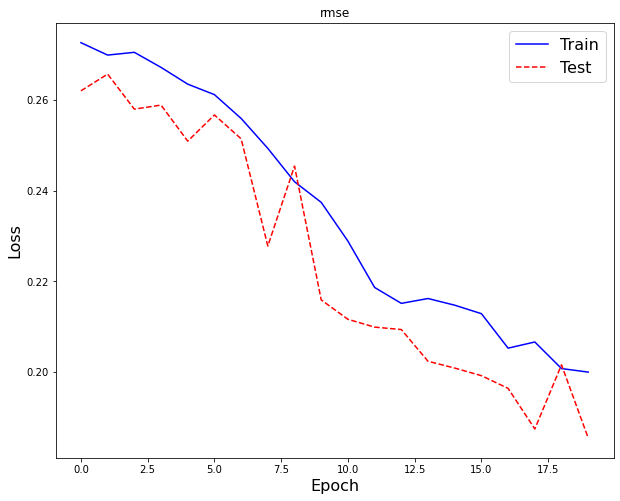

In [349]:
eval_meth = 'rmse'
f, ax = plt.subplots(1,1, figsize=(10,8))

fnt=16
ax.plot(train_loss_mean_rmse, color='blue', label='Train')
ax.plot(val_loss_mean_rmse, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
#ax.tick_params(axis='both', labelsize=fnt)
plt.title(eval_meth)
ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);
f.savefig(eval_meth+'.jpg')

# Task 3.2

## Data Handling and Preprocessing

In [8]:
#todo

## Model Implementation

In [9]:
#todo

## Model Training

In [10]:
#todo

## Evaluation

In [11]:
#todo